<a href="https://colab.research.google.com/github/sangttruong/Titanic/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic: Machine Learning from Disaster**
*Author: Sang Truong*

*Data Science Group at DePauw University, Fall 2019*

**Abstract:** In this analysis, I evaluate the performance of several approaches on a classification problem, the survival of Titanic passengers. Logistic Regression, Gausian Naive Bayes, Support Vector Machine, k-Nearest Neighbor, Decision Tree, and Random Forest were consider. I apply feature engineer to recode 2 categorical variables. Synthetic Minority Over-sampling Technique was used to overcome the issue of imbalance data. Stattistical interpolation was used to handle missing data. I found that, among the considered methods, Random Forest yields the highest in-sample predicting accuracy (85%) with cross-validation.

## **Section 1. Data Importing and Data Cleaning**

In [0]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Titanic/'

train = pd.read_csv(path + 'train.csv')
testX = pd.read_csv(path + 'test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Section 1.1. Data Cleaning for Test set**

In [0]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
# Check for missing data
var = ['Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
for i in var: 
  print(i, ':',  train[i].isna().sum())

Survived : 0
Name : 0
Sex : 0
Age : 177
SibSp : 0
Parch : 0
Ticket : 0
Fare : 0
Cabin : 687
Embarked : 2


In [0]:
# Recode Male
train['Male'] = np.nan
for i in range (len(train)):
  if train.loc[i, 'Sex'] == 'male': train.loc[i, 'Male'] = 1
  if train.loc[i, 'Sex'] == 'female': train.loc[i, 'Male'] = 0
train.drop('Sex', axis = 1, inplace = True)

# Recode Embarked
train['C'] = np.nan
train['Q'] = np.nan
for i in range (len(train)):
  if train.loc[i, 'Embarked'] == 'C':
    train.loc[i, 'C'] = 1
    train.loc[i, 'Q'] = 0
  if train.loc[i, 'Embarked'] == 'Q':
    train.loc[i, 'C'] = 0
    train.loc[i, 'Q'] = 1
  if train.loc[i, 'Embarked'] == 'S':
    train.loc[i, 'C'] = 0
    train.loc[i, 'Q'] = 0

train.drop('Embarked', axis = 1, inplace = True)
train.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Male,C,Q
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0.0,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1.0,0.0,0.0


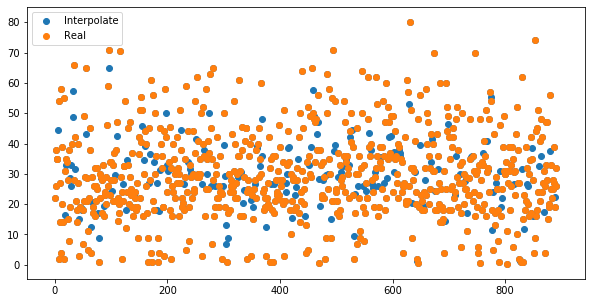

In [0]:
# Interpolate data
old_age = train['Age']
train = train.interpolate()
plt.figure(figsize = (10,5))
plt.scatter(train['PassengerId'], train['Age'], label = 'Interpolate')
plt.scatter(train['PassengerId'], old_age, label = 'Real')
plt.legend()
plt.show()

In [0]:
# Drop Name, Ticket, Cabin and NA
train = train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
train.dropna(inplace = True)

In [0]:
# Check for imbalance in dependent variable
survNum = train[train['Survived'] == 1].Survived.count()
notSurvNum = train[train['Survived'] == 0].Survived.count()

print('Number of survival:', survNum)
print('Number of not survival:', notSurvNum)

Number of survival: 342
Number of not survival: 549


In [0]:
# Oversample minority
SMOTE= SMOTE(sampling_strategy='minority', random_state=7)
x = train[['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Male', 'C', 'Q']]
y = train['Survived']
x = x.to_numpy()
y = y.to_numpy()
x_OS, y_OS = SMOTE.fit_sample(x, y)
OS = pd.DataFrame(data = x_OS)
OS.rename(columns={0:'PassengerId', 1:'Pclass', 2:'Age', 3:'SibSp', 4:'Parch', 5:'Fare', 6:'Male', 7:'C', 8:'Q'}, inplace=True)
OS['Survived'] = y_OS

# Check for dependent variable after oversampling
survNum = OS[OS['Survived'] == 1].Survived.count()
notSurvNum = OS[OS['Survived'] == 0].Survived.count()

print('Number of survival:', survNum)
print('Number of not survival:', notSurvNum)

Number of survival: 549
Number of not survival: 549


In [0]:
# Inspect train dataset
OS.head(5)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Male,C,Q,Survived
0,1.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,0
1,2.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,1
2,3.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1
3,4.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1
4,5.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,0


In [0]:
# Assign dependent and independent variables
X = OS[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Male', 'C', 'Q']]
Y = OS['Survived']

In [0]:
# Correlation matrix
OS.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Male,C,Q,Survived
PassengerId,1.000000,-0.052054,0.040898,-0.040063,0.008561,0.024860,0.063897,0.014760,-0.042158,-0.021115
Pclass,-0.052054,1.000000,-0.308289,0.060979,0.020668,-0.578035,0.163942,-0.252254,0.230755,-0.336526
Age,0.040898,-0.308289,1.000000,-0.196631,-0.182889,0.095021,0.035873,-0.009614,0.020663,-0.056257
SibSp,-0.040063,0.060979,-0.196631,1.000000,0.397365,0.165495,-0.100644,-0.054026,-0.037638,-0.044766
Parch,0.008561,0.020668,-0.182889,0.397365,1.000000,0.207399,-0.220856,-0.005587,-0.097894,0.069121
Fare,0.024860,-0.578035,0.095021,0.165495,0.207399,1.000000,-0.201536,0.293580,-0.131319,0.239058
Male,0.063897,0.163942,0.035873,-0.100644,-0.220856,-0.201536,1.000000,-0.109191,-0.081027,-0.551483
C,0.014760,-0.252254,-0.009614,-0.054026,-0.005587,0.293580,-0.109191,1.000000,-0.155448,0.185725
Q,-0.042158,0.230755,0.020663,-0.037638,-0.097894,-0.131319,-0.081027,-0.155448,1.000000,0.005609
Survived,-0.021115,-0.336526,-0.056257,-0.044766,0.069121,0.239058,-0.551483,0.185725,0.005609,1.000000


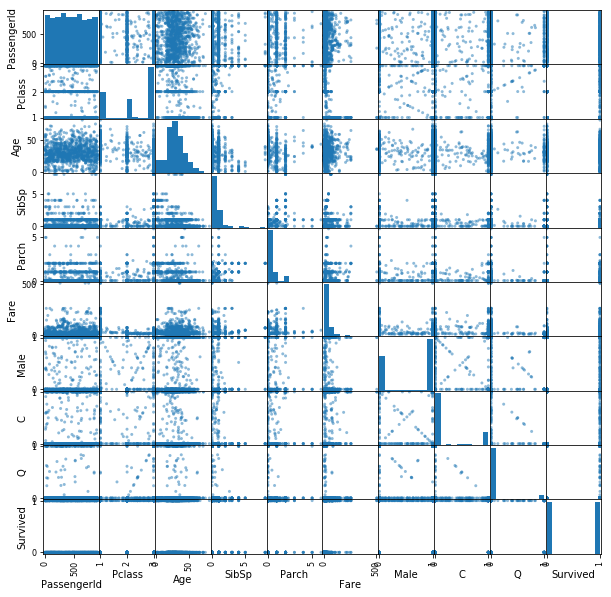

In [0]:
# Correlation graph
scatter_matrix(OS, figsize=(10, 10))
plt.show()

### **Section 1.2. Data Cleaning for Testing set**

In [0]:
# Recode Male
testX['Male'] = np.nan
for i in range (len(testX)):
  if testX.loc[i, 'Sex'] == 'male': testX.loc[i, 'Male'] = 1
  if testX.loc[i, 'Sex'] == 'female': testX.loc[i, 'Male'] = 0
testX.drop('Sex', axis = 1, inplace = True)

# Recode Embarked
testX['C'] = np.nan
testX['Q'] = np.nan
for i in range (len(testX)):
  if testX.loc[i, 'Embarked'] == 'C':
    testX.loc[i, 'C'] = 1
    testX.loc[i, 'Q'] = 0
  if testX.loc[i, 'Embarked'] == 'Q':
    testX.loc[i, 'C'] = 0
    testX.loc[i, 'Q'] = 1
  if testX.loc[i, 'Embarked'] == 'S':
    testX.loc[i, 'C'] = 0
    testX.loc[i, 'Q'] = 0

testX.drop('Embarked', axis = 1, inplace = True)
testX.head(5)

# Interpolate data
testX = testX.interpolate()

# Drop Name, Ticket, Cabin and NA
testX = testX.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
testX.dropna(inplace = True)

# Inspect testX
testX.head(5)

,Pclass,Age,SibSp,Parch,Fare,Male,C,Q
0,3,34.5,0,0,7.8292,1.0,0.0,1.0
1,3,47.0,1,0,7.0000,0.0,0.0,0.0
2,2,62.0,0,0,9.6875,1.0,0.0,1.0
3,3,27.0,0,0,8.6625,1.0,0.0,0.0
4,3,22.0,1,1,12.2875,0.0,0.0,0.0


In [0]:
# Correlation matrix
testX.corr()

,Pclass,Age,SibSp,Parch,Fare,Male,C,Q
Pclass,1.000000,-0.406561,0.001087,0.018721,-0.577433,0.108615,-0.318543,0.252608
Age,-0.406561,1.000000,-0.064067,0.002051,0.311229,0.037744,0.151543,-0.042646
SibSp,0.001087,-0.064067,1.000000,0.306895,0.171993,-0.099943,-0.016365,-0.098824
Parch,0.018721,0.002051,0.306895,1.000000,0.230383,-0.159120,-0.005791,-0.132948
Fare,-0.577433,0.311229,0.171993,0.230383,1.000000,-0.192164,0.312586,-0.155114
Male,0.108615,0.037744,-0.099943,-0.159120,-0.192164,1.000000,-0.033684,-0.115574
C,-0.318543,0.151543,-0.016365,-0.005791,0.312586,-0.033684,1.000000,-0.199786
Q,0.252608,-0.042646,-0.098824,-0.132948,-0.155114,-0.115574,-0.199786,1.000000


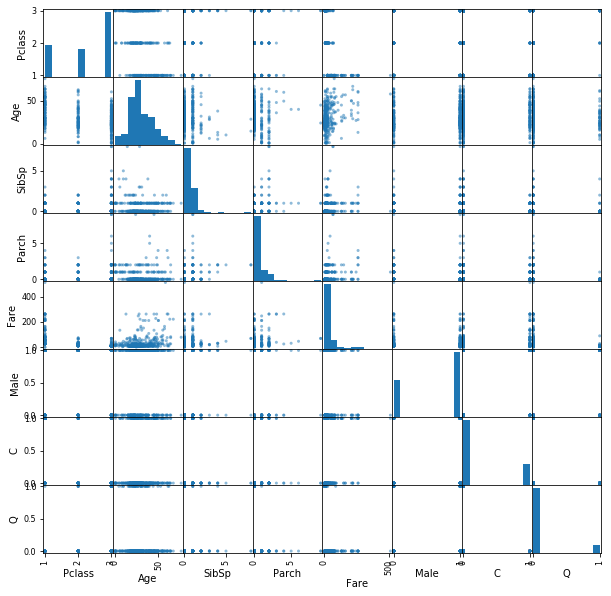

In [0]:
# Correlation graph
scatter_matrix(testX, figsize=(10, 10))
plt.show()

### **Section 1.3. Result Grid**

In [0]:
result = pd.DataFrame()
pred = pd.DataFrame()

In [0]:
pred

""


In [0]:
result

""


## **Section 2. Logistic Regression**

In [0]:
# Logit model
logit = LogisticRegression(solver = 'liblinear' )
scores = cross_val_score(logit, X, Y, cv=10, scoring='accuracy')
result.loc[0, 'Logit'] = scores.mean()

# Predict on test set
logit = LogisticRegression(solver = 'liblinear').fit(X, Y)
pred['Logit'] = logit.predict(testX)

# Summary of logit model
logit = sm.Logit(Y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.520839
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 1098
Model:                          Logit   Df Residuals:                     1090
Method:                           MLE   Df Model:                            7
Date:                Sat, 23 Nov 2019   Pseudo R-squ.:                  0.2486
Time:                        19:27:45   Log-Likelihood:                -571.88
converged:                       True   LL-Null:                       -761.08
Covariance Type:            nonrobust   LLR p-value:                 1.024e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.2220      0.067      3.325      0.001       0.091       0.353
Age            0.0068      0.

## **Section 3. Gaussian Naive Bayes**

In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB()
scores = cross_val_score(gnb, X, Y, cv = 10, scoring = 'accuracy')
result['GNB'] = scores.mean()

# Predict on test set
gnb.fit(X, Y)
pred['GNB'] = gnb.predict(testX)

## **Section 4. k-Nearest Neighbor Classifier**

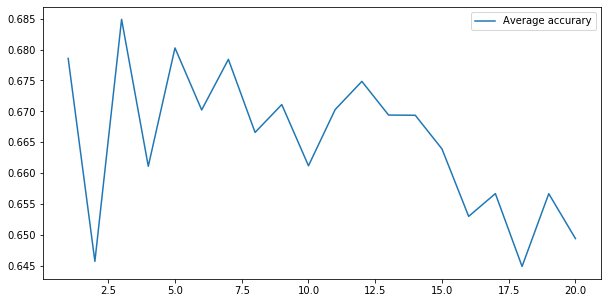

In [0]:
# Tune hyperparameter k for KNN
cv_scores = pd.DataFrame(columns = ['k', 'CV score'] )
neighbors = list(range(1, 21, 1))

i = 0
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
  cv_scores.loc[i, 'k'] = k
  cv_scores.loc[i, 'CV score'] = scores.mean()
  i = i + 1

max_score = cv_scores['CV score'].max()
best_k = cv_scores.loc[cv_scores['CV score'] == max_score, 'k']
result['KNN'] = max_score

# Predict on test set
knn = KNeighborsClassifier(n_neighbors = int(best_k)).fit(X, Y)
pred['KNN'] = knn.predict(testX)

# Plot
plt.figure(figsize= (10,5))
plt.plot(cv_scores['k'], cv_scores['CV score'], label = 'Average accurary')
plt.legend()
plt.show()

## **Section 5. Tree-based Method**

### **Section 5.1. Decision Tree: Exhaustive search for Max Depth**

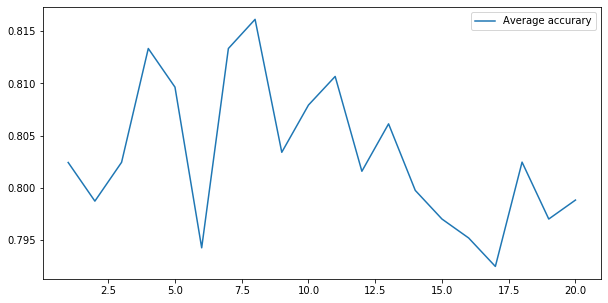

In [0]:
# Tune hyperparameter max_depth
cv_scores = pd.DataFrame(columns = ['Depth', 'CV score'] )
depth = list(range(1, 21, 1))

i = 0
for d in depth:
  tree = DecisionTreeClassifier(random_state=0, max_depth = d)
  scores = cross_val_score(tree, X, Y, cv = 10, scoring = 'accuracy')
  cv_scores.loc[i, 'Depth'] = d
  cv_scores.loc[i, 'CV score'] = scores.mean()
  i = i + 1

max_score = cv_scores['CV score'].max()
best_d = cv_scores.loc[cv_scores['CV score'] == max_score, 'Depth']
result['Tree opt.d'] = max_score

# Predict on test set
tree = DecisionTreeClassifier(random_state=0, max_depth = int(best_d)).fit(X, Y)
pred['Tree opt.d'] = tree.predict(testX)

# Plot
plt.figure(figsize= (10,5))
plt.plot(cv_scores['Depth'], cv_scores['CV score'], label = 'Average accurary')
plt.legend()
plt.show()

In [0]:
# Visualize tree
tree = DecisionTreeClassifier(random_state=0, max_depth=int(best_d)).fit(X, Y)
r = export_text(tree)
# print(r)

### **Section 5.2. Decision Tree: Stochastic Search for Multi-hyperparameters Tuning**

In [0]:
# Run randomized search
tree = DecisionTreeClassifier(random_state=0)
para_dist = {'max_depth': range(1,21,1),
             'max_features' : list(range(1,9,1)),
             'min_samples_split' : np.linspace(start = 0.001, stop = 1, num = 20),
             'min_samples_leaf' : np.linspace(start = 0.001, stop = 0.5, num = 20),
             'criterion': ['gini', 'entropy']}
n_iter_search = 1000
tree_cv = RandomizedSearchCV(tree, param_distributions = para_dist,
                             cv = 10, scoring = 'accuracy', iid = False,
                             n_iter=n_iter_search).fit(X, Y)
result['Tree opt'] = tree_cv.best_score_ 

# Predict on test set
pred['Tree opt'] = tree_cv.predict(testX)

### **Section 5.3. Random Forest: Stochastic Search for Multi-hyperparameters Tuning**

In [0]:
# Turn number of trees: 100
for i in range(100, 1000, 100):
  forest = RandomForestClassifier(n_estimators = i, random_state=0)
  scores = cross_val_score(forest, X, Y, cv = 10, scoring = 'accuracy')
  print(scores.mean())

0.837070707070707
0.8316161616161617
0.8380134680134681
0.8352861952861954
0.8316498316498316
0.8307239057239058
0.8316498316498316
0.8316498316498316
0.8316498316498316


In [0]:
# Tune max depth: 10
depth = np.arange(1, 21,1)
for d in depth:
  forest = RandomForestClassifier(n_estimators = 100, max_depth = d, random_state=0)
  scores = cross_val_score(forest, X, Y, cv = 10, scoring = 'accuracy')
  print(scores.mean())

0.7733838383838384
0.7906565656565656
0.815185185185185
0.828872053872054
0.8297811447811447
0.8352356902356902
0.837053872053872
0.8388888888888889
0.8461616161616161
0.8507407407407408
0.8507239057239058
0.8461616161616161
0.8452525252525254
0.8343602693602694
0.8434680134680136
0.8352693602693604
0.8325420875420877
0.8343434343434343
0.8325252525252524
0.8398148148148149


In [0]:
# Tune max feature: 3
feature = np.arange(1, 9,1)
for f in feature:
  forest = RandomForestClassifier(n_estimators = 100, max_depth = 10,
                                  max_features = f, random_state=0)
  scores = cross_val_score(forest, X, Y, cv = 10, scoring = 'accuracy')
  print(scores.mean())

0.8443771043771043
0.8507407407407408
0.8525420875420876
0.8525084175084174
0.8507070707070709
0.8498148148148148
0.8479966329966331
0.8416329966329966


In [0]:
# Forest temporary
forest = RandomForestClassifier(n_estimators = 100, max_depth = 10,
                                max_features = 3, random_state=0)
scores = cross_val_score(forest, X, Y, cv = 10, scoring = 'accuracy')
result['Forest'] = scores.mean() 

In [0]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 10,
                                max_features = 3, random_state=0).fit(X, Y)
pred['Forest'] = forest.predict(testX)

In [0]:
# # Randomized search
# forest = RandomForestClassifier(random_state=0)

# para_dist = {'n_estimators': [100],
#              'max_depth': list(range(1,21,1)),
#              'max_features' : list(range(1,9,1))}

# n_iter_search = 100
# forest_cv = RandomizedSearchCV(forest, param_distributions = para_dist,
#                              cv = 10, scoring = 'accuracy', iid = False,
#                              n_iter=n_iter_search).fit(X, Y)

###**Section 5.4. Extreme Gradient Boosting**

In [0]:
# https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

## **Section 6. Support Vector Machine**

,0.1,11.2,22.3,33.4,44.5,55.6,66.7,77.8,88.9,100.0
0.01,0.599259,0.557407,0.567441,0.564731,0.562896,0.561077,0.563805,0.563805,0.564714,0.564714
111.12,0.708468,0.613923,0.594798,0.593872,0.589327,0.583872,0.581111,0.58202,0.581111,0.580202
222.23,0.697542,0.613923,0.594798,0.594781,0.588418,0.583872,0.581111,0.58202,0.581111,0.580202
333.34,0.690236,0.613923,0.595707,0.592963,0.588418,0.583872,0.581111,0.58202,0.581111,0.580202
444.45,0.686599,0.613923,0.595707,0.592963,0.588418,0.583872,0.581111,0.58202,0.581111,0.580202
555.56,0.688418,0.613923,0.595707,0.592963,0.588418,0.583872,0.581111,0.58202,0.581111,0.580202
666.67,0.686616,0.613923,0.594798,0.592963,0.588418,0.583872,0.581111,0.58202,0.581111,0.580202
777.78,0.687508,0.613923,0.594798,0.592963,0.588418,0.583872,0.582037,0.58202,0.581111,0.580202
888.89,0.686633,0.613923,0.594798,0.592963,0.588418,0.583872,0.582037,0.58202,0.58202,0.580202
1000.00,0.685707,0.613923,0.594798,0.592963,0.588418,0.583872,0.582037,0.58202,0.58202,0.580202


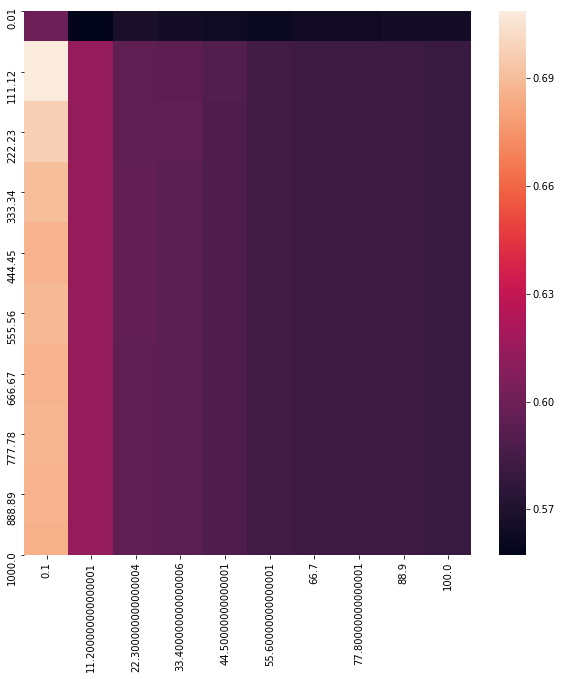

In [0]:
gamma = np.linspace(start = 0.1, stop = 100, num = 10)
C = np.linspace(start = 0.01, stop = 1000, num = 10)
svm_result = pd.DataFrame(columns=gamma, index = C)

for g in gamma:
  for c in C:
    svmachine = svm.SVC(kernel = 'rbf', gamma = g, C = c, random_state = 0)
    scores = cross_val_score(svmachine, X, Y, cv=10, scoring='accuracy')
    svm_result.loc[c, g] = scores.mean()

result['SVM RBF'] = svm_result.max().max()

plt.subplots(figsize=(10,10)) 
heatmap = sns.heatmap(svm_result.astype('float'))
svm_result

,0.1,11.2,22.3,33.4,44.5,55.6,66.7,77.8,88.9,100.0
0.01,0.504545,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
111.12,0.50362,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
222.23,0.499966,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
333.34,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
444.45,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
555.56,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
666.67,0.497222,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
777.78,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
888.89,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1000.00,0.496313,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


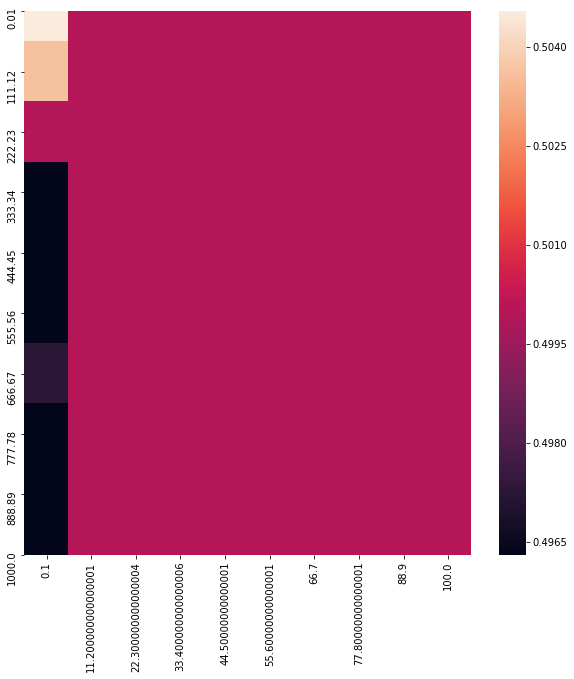

In [0]:
gamma = np.linspace(start = 0.1, stop = 100, num = 10)
C = np.linspace(start = 0.01, stop = 1000, num = 10)
svm_result = pd.DataFrame(columns=gamma, index = C)

for g in gamma:
  for c in C:
    svmachine = svm.SVC(kernel = 'sigmoid', gamma = g, C = c, random_state = 0)
    scores = cross_val_score(svmachine, X, Y, cv=10, scoring='accuracy')
    svm_result.loc[c, g] = scores.mean()

result['SVM Sigmoid'] = svm_result.max().max()

plt.subplots(figsize=(10,10)) 
heatmap = sns.heatmap(svm_result.astype('float'))
svm_result

Stochastic search and Exhaustive search for polynormial kernel are too slow for the timeframe of the project

In [0]:
# gamma = np.linspace(start = 0.1, stop = 100, num = 10)
# C = np.linspace(start = 0.01, stop = 1000, num = 10)
# svm_result = pd.DataFrame(columns=gamma, index = C)

# for g in gamma:
#   for c in C:
#     svmachine = svm.SVC(kernel = 'linear', gamma = g, C = c, random_state = 0)
#     scores = cross_val_score(svmachine, X, Y, cv=10, scoring='accuracy')
#     svm_result.loc[c, g] = scores.mean()

# result['SVM linear'] = svm_result.max().max()

# plt.subplots(figsize=(10,10)) 
# heatmap = sns.heatmap(svm_result.astype('float'))
# svm_result

In [0]:
# This takes a long time to train...

# gamma = np.linspace(start = 0.1, stop = 100, num = 10)
# C = np.linspace(start = 0.01, stop = 1000, num = 10)
# svm_result = pd.DataFrame(columns=gamma, index = C)

# for g in gamma:
#   for c in C:
#     svmachine = svm.SVC(kernel = 'poly', gamma = g, C = c, random_state = 0)
#     scores = cross_val_score(svmachine, X, Y, cv = 10, scoring='accuracy')
#     svm_result.loc[c, g] = scores.mean()

# result['SVM poly'] = svm_result.max().max()

# plt.subplots(figsize=(10,10)) 
# heatmap = sns.heatmap(svm_result.astype('float'))
# svm_result

In [0]:
# # Run randomized search
# svmachine = svm.SVC(random_state = 0)
# para_dist = {'kernel': ['linear', 'rbf', 'sigmoid'],
#              'gamma' : np.linspace(start = 0.01, stop = 100, num = 10),
#              'C' : np.linspace(start = 0.01, stop = 1000, num = 10)}
# n_iter_search = 100
# tree_cv = RandomizedSearchCV(svmachine, param_distributions = para_dist,
#                              cv = 10, scoring = 'accuracy', iid = False,
#                              n_iter=n_iter_search).fit(X, Y)
# result['SVM'] = svm.best_score_

# # Predict on test set
# pred['SVM'] = svm.predict(testX)

## **Section 7. Conclusion**

In [0]:
result

,Logit,GNB,KNN,Tree opt.d,Tree opt,Forest,SVM RBF,SVM Sigmoid
0,0.773165,0.751279,0.684899,0.816145,0.813367,0.852542,0.708468,0.504545


In [0]:
pred.head(5)

,Logit,GNB,KNN,Tree opt.d,Tree opt,Forest
0,0,0,0,0,0,0
1,1,1,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,1,1,0,0,0,1
...,...,...,...,...,...,...
413,0,0,0,0,0,0
414,1,1,1,1,1,1
415,0,0,0,0,0,0
416,0,0,0,0,0,0


In [0]:
# Create submit file
test = pd.read_csv(path + 'test.csv')
submit = pd.DataFrame(data = pred['Forest'])
d = pd.DataFrame(data = test['PassengerId'])
submit = pd.merge(d, submit, left_index=True, right_index=True)
submit.to_csv(path + 'submit.csv')